In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.cluster import KMeans
import copy

import sys
sys.path.append("lib")

import lib

import torch
torch.set_default_dtype(torch.float64)

from functorch import vmap
from torch.utils.data import DataLoader
import tqdm

from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

/home/peiyi/mambaforge3/envs/rom/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda")

In [3]:
coords_x, coords_y, _ = lib.utils.read_coords("2d_burger_data_25_25/time_step_0.csv")
coords = torch.stack((coords_x, coords_y), dim=1)
N = coords.shape[0]

In [4]:
S = 501

u = lib.utils.read_data(S, N, '2d_burger_data_25_25/time_step_', 'vel_0')
u.shape

torch.Size([501, 2601])

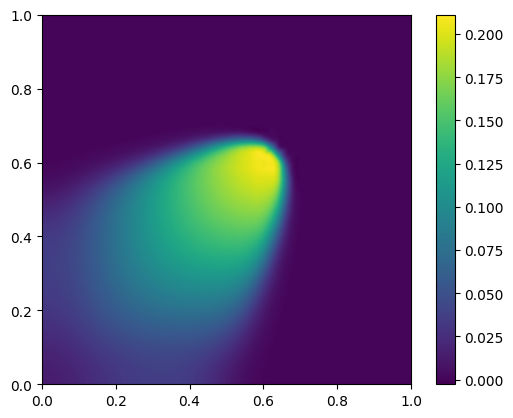

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = u[500].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

In [6]:
m = 50
clustering = KMeans(n_clusters=m, random_state=0, n_init="auto").fit(coords)

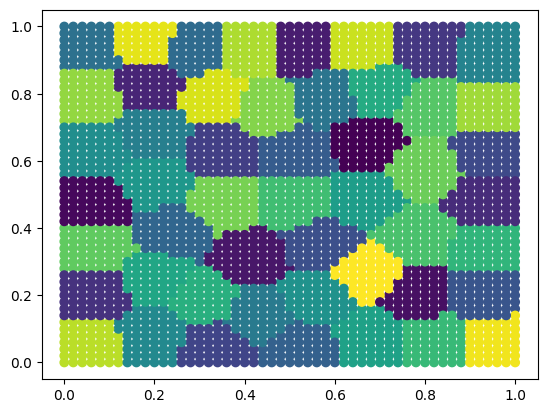

In [7]:
plt.scatter(coords_x, coords_y,c=clustering.labels_)

In [8]:
n = 20
# fixed support (length)
mu = int(np.ceil(N/10))
# mu = N
neighbour_distance, neighbour_id = lib.utils.topk_neighbours(coords, mu)

In [9]:
u_min = torch.min(u)
u_max = torch.max(u)

# u = 2*u/(u_max-u_min) - (u_max+u_min)/(u_max-u_min)
# u = u/(u_max-u_min) - u_min/(u_max-u_min)

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(u)

u_normalized = scaler.transform(u)
u_normalized = torch.tensor(u_normalized)

In [11]:
batch_size = 10
u_normalized = u_normalized.to(device)
dataloader = DataLoader(u_normalized, batch_size=batch_size, shuffle=True)

In [12]:
ed = lib.nrbs_hot_map.EncoderDecoder(N=N, n=n, mu=mu, m=[100, m], B0=1/25, neighbour_id=neighbour_id, neighbour_distance=neighbour_distance, clustering_labels=torch.tensor(clustering.labels_).type(torch.LongTensor), device=device)

In [13]:
# ed.nrbs = torch.load('models/test_hotmap_25_25_100_100_N_10_m_50.pth')

In [14]:
ed.train(dataloader, effective_batch=8, comment="test_hotmap_25_25_100_100_N_10_m_50_column_normalized_0_1", model_name = "models/test_hotmap_25_25_100_100_N_10_m_50_column_normalized_0_1.pth", epochs=1000)

100%|██████████| 51/51 [00:02<00:00, 17.43it/s]


Initial loss = 0.2053440934580942


KeyboardInterrupt: 

In [ ]:
ed(u_normalized[500:501])[0].shape

torch.Size([2601])

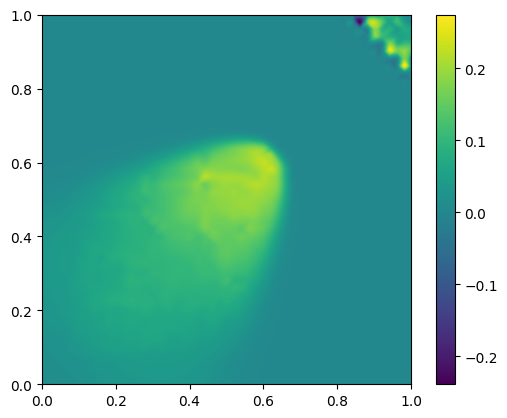

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = ed(u_normalized[500:501])[0]
# z = (z + (u_max + u_min) / (u_max - u_min)) * (u_max - u_min) / 2
# z = (z + u_min / (u_max - u_min)) * (u_max - u_min)
z = scaler.inverse_transform(z.detach().cpu().reshape(1, -1))
z = z.tolist()
z = z[0]

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

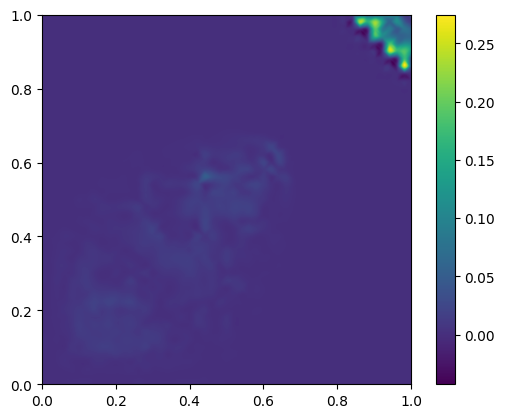

In [ ]:
# label = u[500]
# # label = (label + (u_max + u_min) / (u_max - u_min)) * (u_max - u_min) / 2
# label = (label + u_min / (u_max - u_min)) * (u_max - u_min)

# pred = ed(u[500:501])[0]
# # pred = (pred + (u_max + u_min) / (u_max - u_min)) * (u_max - u_min) / 2
# pred = (pred + u_min / (u_max - u_min)) * (u_max - u_min)

label = u[500].detach().cpu().reshape(1, -1)
pred = ed(u_normalized[500:501])[0]
pred = scaler.inverse_transform(pred.detach().cpu().reshape(1, -1))


z = (abs(label - pred)).tolist()
z = z[0]



# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

In [ ]:
max(z)

0.2678883133591786